# Logistic regression with concept drift

In [1]:
import jax
import pandas as pd
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [3]:
from tqdm import tqdm
from functools import partial
from bayes_opt import BayesianOptimization

In [4]:
from rebayes_mini.methods.gauss_filter import BernoulliFilter
from rebayes_mini.callbacks import get_predicted_mean, get_predicted_bel
from rebayes_mini.methods.adaptive import ExpfamRLSR,  ExpfamEBA, ExpfamRLPR

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## Data generating process

In [7]:
std = 0.01
eps = 0.01

def step(weights, key):
    key_change, key_jump, key_new_weights = jax.random.split(key, 3)
    
    delta_weights = jax.random.normal(key_change, (2,)) * std
    new_weights = jax.random.uniform(key_jump, (2,), minval=-2, maxval=2)
    is_jump = jax.random.uniform(key_new_weights) < eps

    weights = (weights + delta_weights) * (1 - is_jump) + new_weights * is_jump
    return weights, weights


def run_sample_drift_jump_weights(key, n_timesteps):
    key_init, key_run = jax.random.split(key)
    keys = jax.random.split(key, n_timesteps)

    init_weights = jax.random.uniform(key_init, (2,), minval=-2, maxval=2)
    _, weights = jax.lax.scan(step, init_weights, keys)
    return weights


@partial(jax.jit, static_argnames=("n_timesteps",))
def run_sample_drift_jump(key, n_timesteps):
    key_weights, key_x, key_y = jax.random.split(key, 3)
    weights = run_sample_drift_jump_weights(key_weights, n_timesteps)

    x_samples = jax.random.uniform(key_x, minval=-3, maxval=3, shape=(n_timesteps,2))
    y_samples = jax.nn.sigmoid(jnp.einsum("sm,sm->s", weights, x_samples))
    y_samples = jax.random.bernoulli(key_y, p=y_samples)

    return (x_samples, y_samples), weights

In [8]:
key = jax.random.PRNGKey(314)
n_timesteps = 720
(x_samples, y_samples), weights = run_sample_drift_jump(key, n_timesteps)

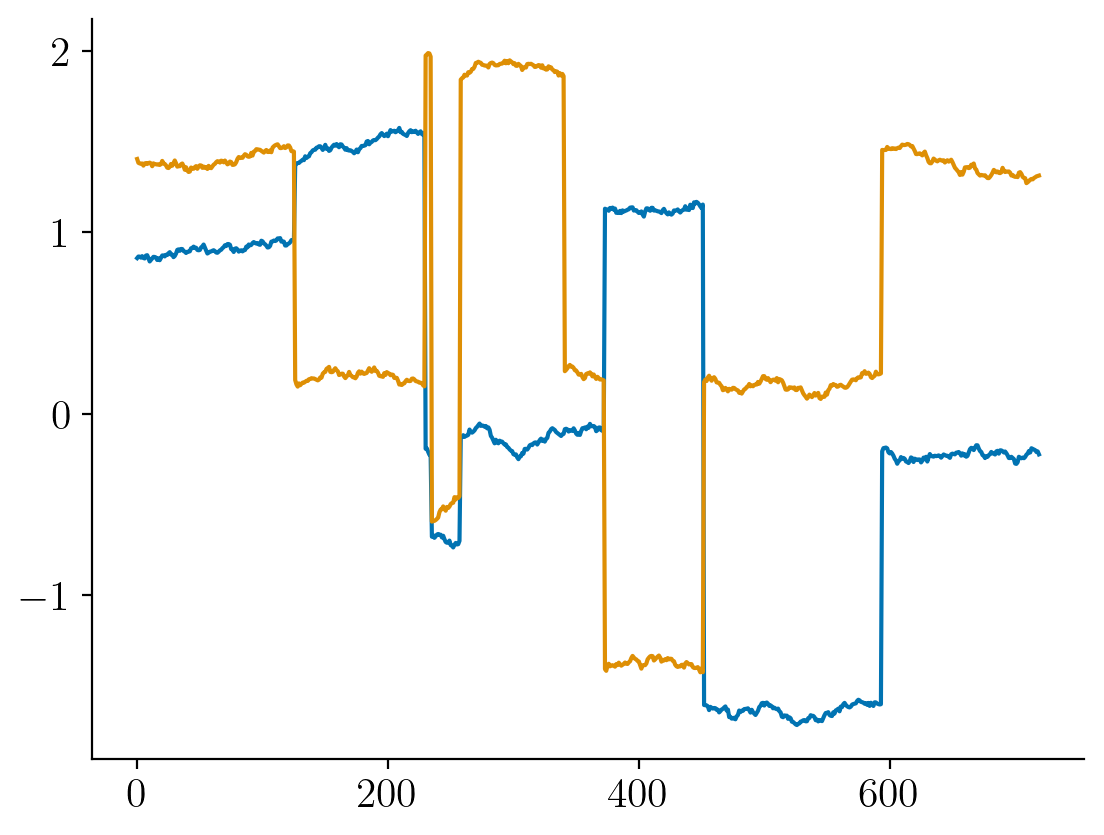

In [9]:
plt.plot(weights)

## Dataset generating process

In [10]:
key = jax.random.PRNGKey(314)
n_tests = 100
n_timesteps = 720
key_warmup, key_test = jax.random.split(key)
keys_test = jax.random.split(key_test, n_tests)

(x_samples, y_samples), weights = run_sample_drift_jump(key_warmup, n_timesteps)
(x_test, y_test), _  = jax.vmap(run_sample_drift_jump, in_axes=(0, None))(keys_test, n_timesteps)

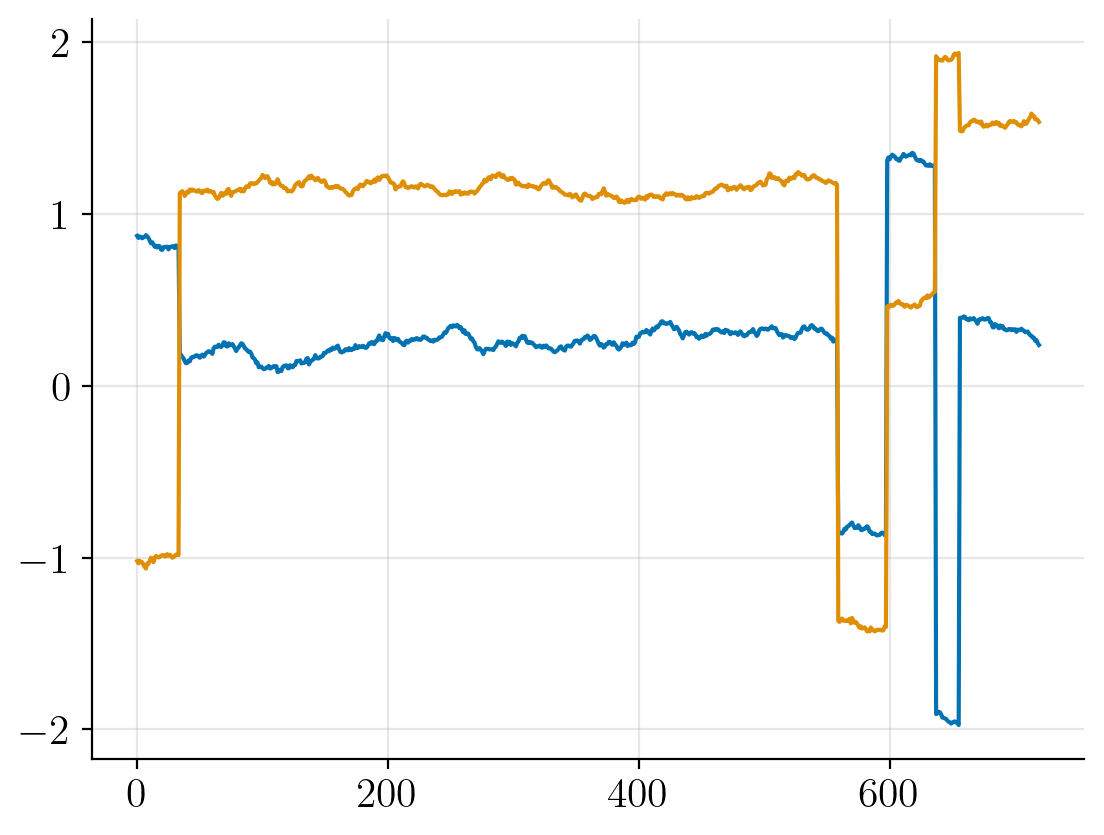

In [11]:
plt.plot(weights)
plt.grid(alpha=0.3)

## Fitting

In [12]:
results = {}

In [13]:
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

In [14]:
base_filter = BernoulliFilter(apply_fn, dynamics_covariance=0.0)

## C-ACI

In [15]:
def run_caci(q, y, x):
    filter = BernoulliFilter(apply_fn, dynamics_covariance=q)
    mean_init = jnp.zeros(2)
    bel_init = filter.init_bel(mean_init, cov=1.0)
    bel_final, hist = filter.scan(bel_init, y, x, get_predicted_mean)
    return hist

@jax.jit
def eval_caci(q, y, x):
    mean =  run_caci(q, y, x)
    yhat = jnp.einsum("sm,sm->s", mean.squeeze(), x)
    return (jax.nn.sigmoid(yhat).round() == y.ravel()).mean()

### Warmup

In [16]:
bo = BayesianOptimization(
    partial(eval_caci, y=y_samples[:, None], x=x_samples),
    pbounds = {"q": (0.0, 10.0)},
    random_state=314,
    verbose=1
)
bo.maximize()

|   iter    |  target   |     q     |
-------------------------------------
| 2         | 0.8014    | 5.885     |
| 3         | 0.8028    | 2.65      |
| 30        | 0.8042    | 0.8364    |


### Test

In [17]:
q = bo.max["params"]["q"].item()
res_caci = jax.vmap(eval_caci, in_axes=(None, 0, 0))(q, y_test[..., None], x_test)
res_caci.mean()

Array(0.76500005, dtype=float32)

## RL-PR

In [18]:
def run_rlpr(p, K, y, x):
    filter = ExpfamRLPR(p, K=1, filter=base_filter)
    mean_init = jnp.zeros(2)
    bel_init = filter.init_bel(mean_init, cov=1.0, log_joint_init=0.0)
    bel_final, hist = filter.scan(y, x, bel_init, get_predicted_bel)
    return hist


@partial(jax.jit, static_argnames=("K",))
def eval_rlpr(p, K, y, x):
    hist =  run_rlpr(p, K, y, x)
    log_joint = hist.log_joint
    posterior = jnp.exp(log_joint - jax.nn.logsumexp(log_joint, axis=1, keepdims=True))
    yhat = jnp.einsum("tk,tkm,tm->t", posterior, hist.mean, x)

    return (jax.nn.sigmoid(yhat).round() == y.ravel()).mean()

### Warmup

In [19]:
bo = BayesianOptimization(
    partial(eval_rlpr, y=y_samples[:, None], x=x_samples, K=5),
    pbounds = {"p": (0.0, 1.0)},
    random_state=314,
    verbose=1
)
bo.maximize()

|   iter    |  target   |     p     |
-------------------------------------
| 3         | 0.6597    | 0.265     |


### Test

In [20]:
p = bo.max["params"]["p"].item()
res_rlpr = jax.vmap(eval_rlpr, in_axes=(None, None, 0, 0))(p, 5, y_test[..., None], x_test)
res_rlpr.mean()

Array(0.6085277, dtype=float32)

## RL-OUPR

In [21]:
def run_rlspr(p, y, x):
    filter = ExpfamRLSR(p, K=1, shock=1.0, deflate_mean=True, filter=base_filter)
    mean_init = jnp.zeros(2)
    bel_init = filter.init_bel(mean_init, cov=1.0, log_joint_init=0.0)
    bel_final, hist = filter.scan(y, x, bel_init, get_predicted_bel)
    return hist


@partial(jax.jit)
def eval_rlspr(p, y, x):
    hist =  run_rlspr(p, y, x)
    log_joint = hist.log_joint
    posterior = jnp.exp(log_joint - jax.nn.logsumexp(log_joint, axis=1, keepdims=True))
    yhat = jnp.einsum("tk,tkm,tm->t", posterior, hist.mean, x)

    return (jax.nn.sigmoid(yhat).round() ==  y.ravel()).mean()

### Warmup

In [22]:
bo = BayesianOptimization(
    partial(eval_rlspr, y=y_samples[:, None], x=x_samples),
    pbounds = {"p": (0.0, 1.0)},
    random_state=314,
    verbose=1
)
bo.maximize()

|   iter    |  target   |     p     |
-------------------------------------
| 3         | 0.7986    | 0.265     |
| 6         | 0.8208    | 0.03837   |
| 30        | 0.8222    | 0.1305    |


### Test

In [23]:
p = bo.max["params"]["p"].item()
res_rlspr = jax.vmap(eval_rlspr, in_axes=(None, 0, 0))(p, y_test[..., None], x_test)

In [24]:
res_rlspr.mean()

Array(0.76680565, dtype=float32)

## CPP-OU

In [25]:
def run_cppd(drift, lr, y, x):
    filter = ExpfamEBA(
        n_inner=1, ebayes_lr=lr, state_drift=drift,
        deflate_mean=True, deflate_covariance=True, filter=base_filter
    )
    mean_init = jnp.zeros(2)
    bel_init = filter.init_bel(mean_init, cov=1.0)
    bel_final, hist = filter.scan(y, x, bel_init, get_predicted_mean)
    return hist


@partial(jax.jit)
def eval_cppd(drift, lr, y, x):
    mean = run_cppd(drift, lr, y, x)

    yhat = jnp.einsum("sm,sm->s", mean.squeeze(), x)
    return (jax.nn.sigmoid(yhat).round() == y.ravel()).mean()

### Warmup

In [26]:
bo = BayesianOptimization(
    partial(eval_cppd, y=y_samples[:, None], x=x_samples),
    pbounds = {"drift": (0.0, 2.0), "lr": (0.0, 1.0)},
    random_state=314,
    verbose=1
)
bo.maximize()

|   iter    |  target   |   drift   |    lr     |
-------------------------------------------------
| 2         | 0.7153    | 0.5301    | 0.7832    |
| 4         | 0.7236    | 1.456     | 0.2605    |
| 6         | 0.7431    | 0.8764    | 0.2295    |
| 7         | 0.8125    | 0.6555    | 0.002086  |
| 11        | 0.8361    | 0.005331  | 0.4459    |


In [27]:
lr = bo.max["params"]["lr"].item()
drift = bo.max["params"]["drift"].item()
res_cppd = jax.vmap(eval_cppd, in_axes=(None, None, 0, 0))(
    lr, drift, y_test[..., None], x_test
)

In [28]:
res_cppd.mean()

Array(0.7636389, dtype=float32)

## results

In [29]:
results = {
    "RL-OUPR": res_rlspr,
    "RL-PR": res_rlpr,
    "CPP-OU": res_cppd,
    "C-ACI": res_caci,
}
results = jax.tree.map(np.array, results)
results = pd.DataFrame(results)

In [30]:
missclasification = 1 - results
missclasification = missclasification.rename({"RL-OUPR": "RL-OUPR*"}, axis=1)

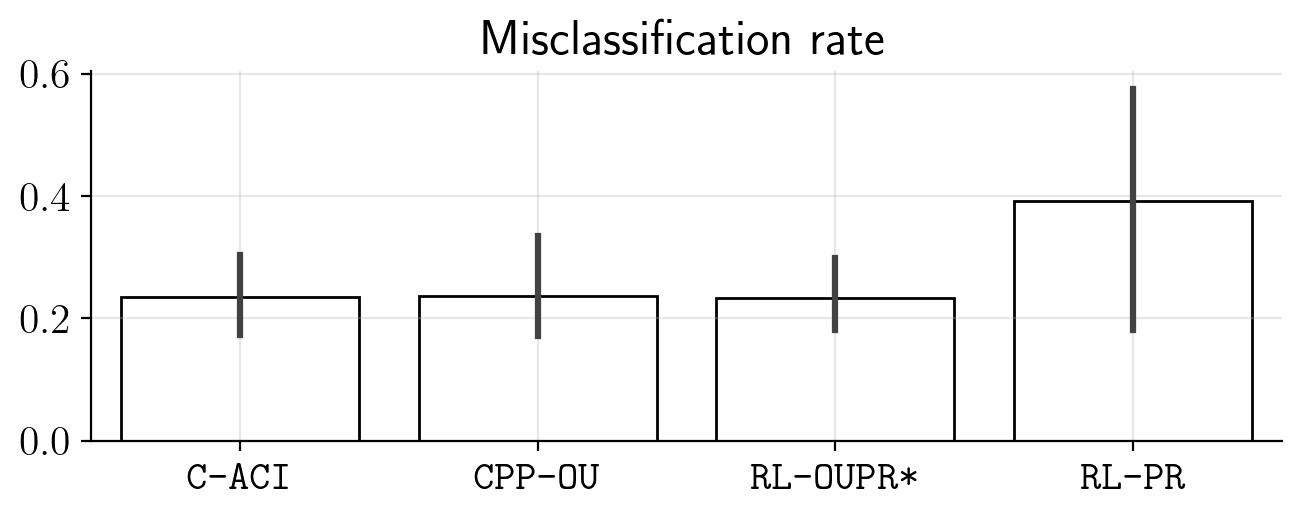

In [32]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

sns.barplot(
    x="variable",
    y="value",
    data=missclasification.melt(),
    color="white",
    edgecolor="black",
    errorbar=("pi", 95)
)

# for ticklabel in plt.gca().get_xticklabels():
#     label = ticklabel.get_text()
#     tickcolor = "teal" if "SPR" in label else "crimson"
#     ticklabel.set_color(tickcolor)

pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)

plt.title("Misclassification rate")
plt.xlabel("")
plt.ylabel("")
plt.grid(alpha=0.3)

plt.savefig("../figures/clf-accuracy-abrupt.png", dpi=300, bbox_inches="tight")

---


# RL-PR with varying $K$

In [33]:
def run_rlpr(p, K, y, x):
    filter = ExpfamRLPR(p, K=K, filter=base_filter)
    mean_init = jnp.zeros(2)
    bel_init = filter.init_bel(mean_init, cov=1.0, log_joint_init=0.0)
    bel_final, hist = filter.scan(y, x, bel_init, get_predicted_bel)
    return hist


@partial(jax.jit, static_argnames=("K",))
def eval_rlpr(p, K, y, x):
    hist =  run_rlpr(p, K, y, x)
    log_joint = hist.log_joint
    posterior = jnp.exp(log_joint - jax.nn.logsumexp(log_joint, axis=1, keepdims=True))
    yhat = jnp.einsum("tk,tkm,tm->t", posterior, hist.mean, x)

    return (jax.nn.sigmoid(yhat).round() == y.ravel()).mean()

### Warmup

In [34]:
bo = BayesianOptimization(
    partial(eval_rlpr, y=y_samples[:, None], x=x_samples, K=5),
    pbounds = {"p": (0.0, 1.0)},
    random_state=314,
    verbose=1
)
bo.maximize()

|   iter    |  target   |     p     |
-------------------------------------
| 2         | 0.825     | 0.5885    |
| 6         | 0.8278    | 0.5371    |
| 13        | 0.8361    | 0.4905    |
| 18        | 0.8375    | 0.4734    |
| 28        | 0.8389    | 0.4638    |


### Test

In [35]:
p = bo.max["params"]["p"].item()
p  = 0.6

In [36]:
%%time
p_values = np.linspace(0, 1, 10)[1:-1]
results_all = []
for p in tqdm(p_values):
    results_rlpr = {
        K: jax.vmap(eval_rlpr, in_axes=(None, None, 0, 0))(p, K, y_test[..., None], x_test)
        for K in range(1, 16)
    }
    
    results_rlpr = jax.tree.map(np.array, results_rlpr)
    results_rlpr = pd.DataFrame(results_rlpr)
    results_rlpr = results_rlpr.melt()
    results_rlpr["p"] = p
    results_all.append(results_rlpr)
results_all = pd.concat(results_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:45<00:00,  5.68s/it]

CPU times: user 1min 10s, sys: 4.3 s, total: 1min 14s
Wall time: 45.5 s


In [37]:
results_all["misclassification"] = 1 - results_all["value"]

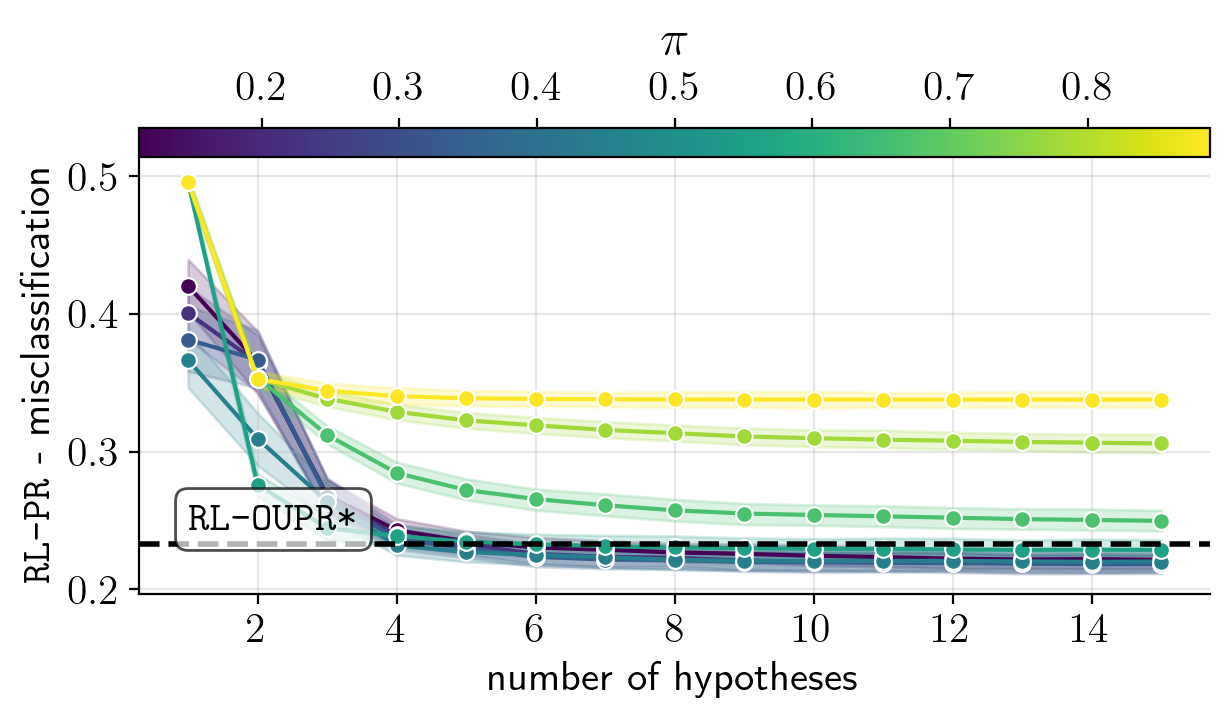

In [38]:
fig = plt.figure(figsize=(6.4, 4.8 * 0.8))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[1,15], hspace=0.0)

ax0 = fig.add_subplot(gs[1])
sns.lineplot(
    x="variable",
    y="misclassification",
    hue="p",
    data=results_all,
    marker="o",
    legend=False,
    palette="viridis"
)
ax0.grid(alpha=0.3)
mcr_spr = 1 - results["RL-OUPR"].mean() # missclasification rate for spr
ax0.set_xlabel("number of hypotheses")
ax0.set_ylabel(r"\texttt{RL-PR} - misclassification")

ax0.axhline(y=mcr_spr, c="black", linestyle="--", linewidth=2)
ax0.text(
    1, mcr_spr + 1e-2, r"\texttt{RL-OUPR*}",
    bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", alpha=0.7)
)

ax1 = fig.add_subplot(gs[0])
norm_values = mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max())
mappable = plt.cm.ScalarMappable(norm=norm_values, cmap="viridis")
plt.colorbar(mappable, cax=ax1, orientation="horizontal")
ax1.xaxis.set_ticks_position("top")
ax1.set_title(r"$\pi$")


plt.tight_layout()
plt.savefig("../figures/clf-rlpr-comparison-abrupt.png", dpi=300, bbox_inches="tight")